In [118]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import random
import csv
from collections import defaultdict
import re

import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/dbpedia-ontology-dataset")

print("Path to dataset files:", path)

random.seed(42)

def load_data(file_name,labels, max_labels=100):
    data = []
    labels_counter = {}
    with open(file_name, 'r', encoding="utf-8") as file:
        first = True
        for row in csv.reader(file):
            if not first:
                label = int(row[0])-1
                if label in labels:
                    data.append(((row[1]+' '+row[2]), label))
            else:
                first = not first
    random.shuffle(data)
    X, y = [], []
    for row in data:
        label = row[1]
        if label not in labels_counter.keys():
            labels_counter[label] = 0
        if labels_counter[label] < max_labels:
            labels_counter[label]+=1
            X.append(row[0])
            y.append(label)
    return X, y

X_doc_train, y_train = load_data(f"{path}/train.csv", labels=(0,1), max_labels=100)
X_doc_test, y_test = load_data(f"{path}/test.csv", labels=(0,1), max_labels=80)
y_train = np.array(y_train)
y_test = np.array(y_test)

Path to dataset files: /home/andry/.cache/kagglehub/datasets/thedevastator/dbpedia-ontology-dataset/versions/2


In [119]:
class MyTfidfVectorizer:
    def __init__(self, token_pattern, min_df=1, max_df=1.0, stop_words=None):
        self.token_pattern = token_pattern
        self.min_df = min_df
        self.max_df = max_df
        self.vocabulary = None
        self.idf = None

    def _preprocess(self, texts):
        processed_texts = []
        for text in texts:
            text = text.lower()
            words = re.findall(r"\b\w+\b", text)
            processed_texts.append(words)
        return processed_texts

    def _build_vocabulary(self, processed_texts):
        doc_count = len(processed_texts)
        word_doc_freq = defaultdict(int)
        for words in processed_texts:
            unique_words = set(words)
            for word in unique_words:
                word_doc_freq[word] += 1
        
        filtered_words = [
            word for word, freq in word_doc_freq.items() 
            if freq >= 1 and freq <= doc_count
        ]
        self.vocabulary = {
            word: idx for idx, word in enumerate(sorted(filtered_words))
        }
        self.idf = np.zeros(len(self.vocabulary))
        for word, idx in self.vocabulary.items():
            doc_freq = word_doc_freq[word]
            self.idf[idx] = np.log((doc_count + 1) / (doc_freq + 1)) + 1

    def _compute_tf(self, words):
        total_words = len(words)
        if total_words == 0:
            return {}
        word_freq = defaultdict(int)
        for word in words:
            word_freq[word] += 1
        tf = {word: freq / total_words for word, freq in word_freq.items()}
        return tf
    def fit(self, texts):
        processed_texts = self._preprocess(texts)
        self._build_vocabulary(processed_texts)
        return self

    def transform(self, texts):
        processed_texts = self._preprocess(texts)
        n_docs = len(processed_texts)
        n_features = len(self.vocabulary)
        tfidf_matrix = np.zeros((n_docs, n_features))
        for doc_idx, words in enumerate(processed_texts):
            tf = self._compute_tf(words)
            for word, tf_value in tf.items():
                if word in self.vocabulary:
                    word_idx = self.vocabulary[word]
                    tfidf_matrix[doc_idx, word_idx] = tf_value * self.idf[word_idx]
        return tfidf_matrix

    def fit_transform(self, texts):
        return self.fit(texts).transform(texts)

In [120]:
vectorizer = TfidfVectorizer(token_pattern=r'\b[a-zA-Z]+\b')
X_train = vectorizer.fit_transform(X_doc_train).toarray()
X_test = vectorizer.transform(X_doc_test).toarray()

In [121]:
class MyStandardScaler:
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        self.std[self.std == 0] = 1.0
        return self
    
    def transform(self, X):
        return (X - self.mean) / self.std
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [122]:
class MySVM:
    def __init__(
        self,
        C=1.0,
        n_iters=1000,
        lr=0.01,
        momentum=0.9,
        gamma=0.8,
        tol=1e-4,
    ):
        self.C = C
        self.n_iters = n_iters
        self.lr = lr
        self.tol = tol
        self.scaler = MyStandardScaler()
        self.gamma = gamma
        self.momentum = momentum

    def _lr_scheduler(self, epoch):
        return self.lr * (self.gamma**epoch)

    def fit(self, X, y):
        X = self.scaler.fit_transform(X)
        n_samples, n_features = X.shape
        labels = np.where(y == 0, -1, 1)
        self.w = np.zeros(n_features)
        self.b = 0
        velocity_w = np.zeros_like(self.w)
        velocity_b = 0.0
        for epoch in range(self.n_iters):
            margins = labels * (np.dot(X, self.w) + self.b)
            support_vectors_indicator = (margins < 1).astype(float)
            grad_w = (
                self.w
                - self.C * np.dot(support_vectors_indicator * labels, X) / n_samples
            )
            grad_b = -self.C * np.sum(support_vectors_indicator * labels) / n_samples
            w_prev = self.w.copy()
            b_prev = self.b
            lr = self._lr_scheduler(epoch)
            velocity_w = self.momentum * velocity_w + grad_w
            velocity_b = self.momentum * velocity_b + grad_b
            self.w -= lr * velocity_w
            self.b -= lr * velocity_b

            if (
                np.linalg.norm(self.w - w_prev) < self.tol
                and abs(self.b - b_prev) < self.tol
            ):
                break

    def predict(self, X):
        X = self.scaler.transform(X)
        approx = np.dot(X, self.w) + self.b
        return np.where(approx >= 0, 1, 0)

In [123]:
my_svm = MySVM()
my_svm.fit(X_train, y_train)
pred_my_svm = my_svm.predict(X_test)
print(classification_report(y_test, pred_my_svm))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        80
           1       1.00      0.99      0.99        80

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



In [124]:
sk_svm = LinearSVC()
sk_svm.fit(X_train, y_train)
pred_sk_svm = sk_svm.predict(X_test)
print(classification_report(y_test, pred_sk_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        80
           1       0.99      0.99      0.99        80

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



In [125]:
class MyLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iter=10000, tol=1e-4, C=1.0, 
                 beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.eta = learning_rate
        self.n_iter = n_iter
        self.scaler = MyStandardScaler()
        self.tol = tol
        self.C = C
        self.beta1 = beta1 
        self.beta2 = beta2
        self.epsilon = epsilon
        
    
    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def _add_bias(self, X):
        return np.c_[np.ones(X.shape[0]), X]
    
    def fit(self, X, y):
        X = self.scaler.fit_transform(X)
        X = self._add_bias(X)
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        m = np.zeros(n_features)
        v = np.zeros(n_features)
        
        for i in range(1, self.n_iter + 1):
            z = np.dot(X, self.w)
            h = self._sigmoid(z)
            grad = np.dot(X.T, (h - y)) / n_samples
            grad[1:] += self.w[1:] / self.C
            
            m = self.beta1 * m + (1 - self.beta1) * grad
            v = self.beta2 * v + (1 - self.beta2) * (grad ** 2)
            m_hat = m / (1 - self.beta1 ** i)
            v_hat = v / (1 - self.beta2 ** i)
            

            self.w -= self.eta * m_hat / (np.sqrt(v_hat) + self.epsilon)
            
            if np.linalg.norm(grad) < self.tol:
                break
    
    def predict_proba(self, X):
        X = self.scaler.transform(X)
        X = self._add_bias(X)
        return self._sigmoid(np.dot(X, self.w))
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

In [126]:
my_lreg = MyLogisticRegression()
my_lreg.fit(X_train, y_train)

y_pred = my_lreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        80
           1       1.00      0.99      0.99        80

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



In [127]:
sk_lreg = LogisticRegression()
sk_lreg.fit(X_train, y_train)

y_pred = sk_lreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        80
           1       0.99      0.99      0.99        80

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



In [128]:
def find_params(model, X_train, y_train, name, k_values=np.logspace(-5, 1, 50)):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    results = []
    res_f1 = -np.inf
    res_alpha = None

    for k in k_values:
        f1_scores = []
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]
            clf = model(C=k)
            clf.fit(X_tr, y_tr)
            y_pred = clf.predict(X_val)
            f1_scores.append(f1_score(y_val, y_pred, average='macro'))
        mean_f1 = np.mean(f1_scores)
        if mean_f1>res_f1:
            res_f1 = mean_f1
            res_alpha = k
        results.append(np.mean(f1_scores))

    plt.figure(figsize=(8, 5))
    plt.plot(k_values, results)
    plt.xlabel('C')
    plt.ylabel('F1 Score')
    plt.title(f'Зависимость F1-score от C для разных метрик ({name})')
    plt.grid(True)
    plt.show()
    return (res_alpha, res_f1)

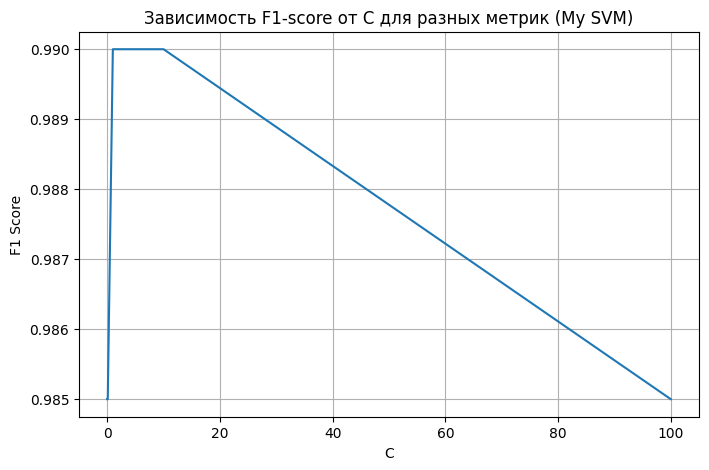

(1, np.float64(0.9899937460913071))

In [129]:
res_alpha, res_f1 = find_params(MySVM, X_train, y_train, "My SVM", k_values=[0.001, 0.01, 0.1, 1, 10, 100])
res_alpha, res_f1

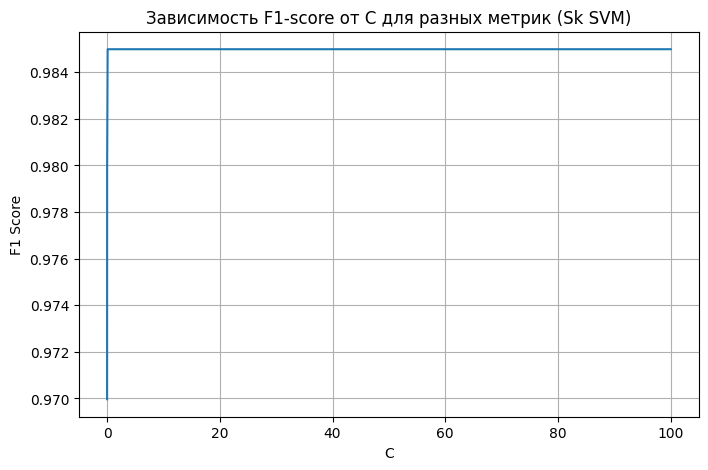

(0.1, np.float64(0.9849906191369605))

In [130]:
res_alpha, res_f1 = find_params(LinearSVC, X_train, y_train, "Sk SVM", k_values=[0.001, 0.01, 0.1, 1, 10, 100])
res_alpha, res_f1

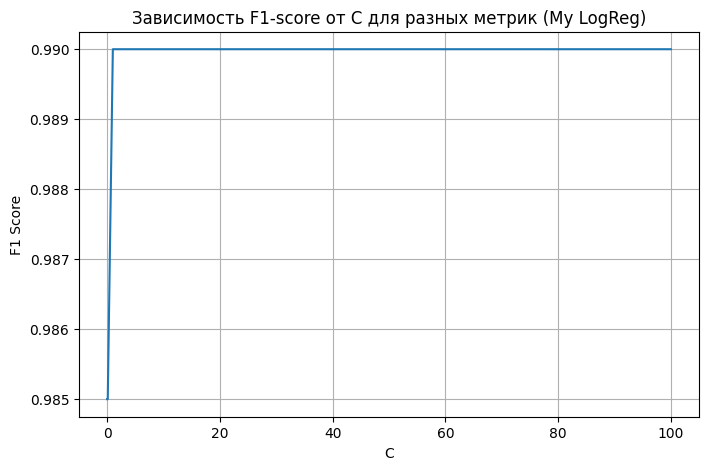

(1, np.float64(0.9899937460913071))

In [131]:
res_alpha, res_f1 = find_params(MyLogisticRegression, X_train, y_train, "My LogReg", k_values=[0.001, 0.01, 0.1, 1, 10, 100])
res_alpha, res_f1

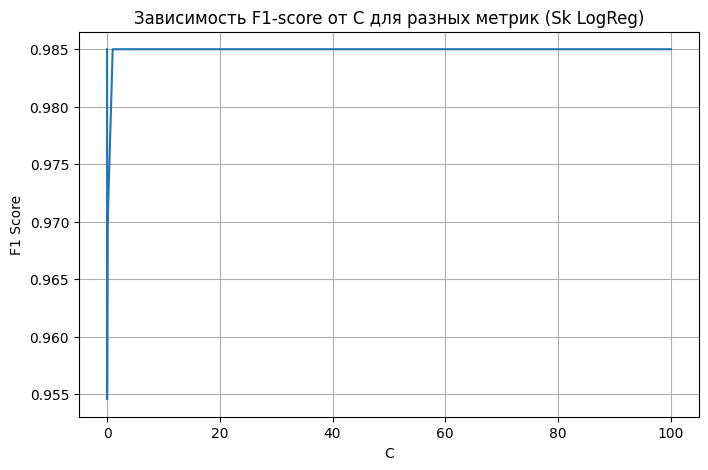

(0.001, np.float64(0.9849906191369605))

In [132]:
res_alpha, res_f1 = find_params(LogisticRegression, X_train, y_train, "Sk LogReg", k_values=[0.001, 0.01, 0.1, 1, 10, 100])
res_alpha, res_f1

# Отчет

В ходе выполнения лабораторной работы была выполнена реализация своих алгоритмов машинного обучения SVM и LogisticRegression для классификации текстов. Было произведено сравнение результатов работы собственных реализаций и реализаций из sklearn. Сильных различий различий обнаружено не было. Также был проведен подбор параметра регуляризации C при помощи К-фолдов. Как итог, библиотечным SVM и LogisticRegression потребовалась более сильная регуляризация, чем моим собственным реализациям.